In [1]:
import yfinance as yf
import time
import pandas as pd
import json
import numpy as np
import xgboost
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
import warnings

warnings.filterwarnings('ignore')


In [2]:
import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
# from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error

In [3]:
hedging_pnl = pd.read_csv('Options constructor dummy - raw_hedging_pnls.csv')
options_pnl = pd.read_csv('Options constructor dummy - raw_options_pnls.csv')

hedging_pnl['0'] = pd.to_datetime(hedging_pnl['0'])
options_pnl['0'] = pd.to_datetime(options_pnl['0'])

options_pnl = options_pnl.set_index('0').astype(float)
hedging_pnl = hedging_pnl.set_index('0').astype(float)

base_features = pd.read_csv('new_features.csv')
base_features['Unnamed: 0'] = pd.to_datetime(base_features['Unnamed: 0'])
base_features = base_features.set_index('Unnamed: 0')
base_features = base_features.resample('W-SUN').sum()

strats = list(hedging_pnl.columns)

In [4]:
strats_data = {}
for i in strats:
    strat_info = (options_pnl[i]+hedging_pnl[i])
    weekly_pnl = strat_info.resample('W-SUN').sum()

    strats_data.update({i:weekly_pnl})

In [9]:
strats_data

{'0.01_10_15_0_put': 0
 2019-10-20    0.100000
 2019-10-27    0.125000
 2019-11-03    0.225000
 2019-11-10    1.405095
 2019-11-17    0.000000
                 ...   
 2023-05-07    0.000000
 2023-05-14    0.000000
 2023-05-21    0.000000
 2023-05-28    0.000000
 2023-06-04    0.000000
 Freq: W-SUN, Name: 0.01_10_15_0_put, Length: 190, dtype: float64,
 '0.01_10_15_0_call': 0
 2019-10-20    0.0500
 2019-10-27   -0.4215
 2019-11-03    0.0750
 2019-11-10    0.0250
 2019-11-17    0.0000
                ...  
 2023-05-07    0.0000
 2023-05-14    0.0000
 2023-05-21    0.0000
 2023-05-28    0.0000
 2023-06-04    0.0000
 Freq: W-SUN, Name: 0.01_10_15_0_call, Length: 190, dtype: float64,
 '0.03_10_15_0_put': 0
 2019-10-20   -1.027405
 2019-10-27    0.475000
 2019-11-03   -0.237405
 2019-11-10    0.500000
 2019-11-17    0.000000
                 ...   
 2023-05-07    0.000000
 2023-05-14    0.000000
 2023-05-21    0.000000
 2023-05-28    0.000000
 2023-06-04    0.000000
 Freq: W-SUN, Name: 0.03_

In [11]:
for strat in strats:
    
    str_data = pd.DataFrame()
    str_data['value'] = strats_data[strats[100]]
    str_data['target'] = str_data['value'].shift(-1)
    
    
    df = pd.merge(str_data, base_features, how = 'inner', right_index = True, left_index = True).dropna()
    df['target'] = np.where(df['target']>=0,1,0)

    features = df.drop('target', axis = 1)
    target = df['target']

    break

In [13]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3)

In [15]:
X_train

,value,^GSPC,^VIX,^VIX9D,^VVIX,Net Gamma,rv5,rv10
2023-02-12,-6.334200,-0.010983,0.118691,0.211717,0.143642,-1.451010,-0.516659,-0.205946
2023-02-19,2.225000,-0.002615,-0.016538,-0.189497,-0.079953,3.842687,0.025495,-0.380886
2023-05-07,1.286830,-0.007715,0.107298,0.033187,0.061162,-2.367714,-0.011343,0.141579
2023-04-16,1.194620,0.008013,-0.071278,-0.149293,-0.006866,4.176810,1.112414,-1.038857
2023-03-19,2.445485,0.014529,0.054818,0.056941,0.169112,-1.031613,-0.383220,0.129777
2023-04-23,0.170875,-0.000972,-0.016256,0.114321,0.148636,-0.607816,0.069561,0.207701
2023-03-12,8.688670,-0.046162,0.314658,0.447098,0.397686,-15.156686,0.951919,0.862649
2023-04-09,1.200000,-0.001011,-0.015192,-0.047392,-0.032531,-0.792282,-1.116451,0.163595
2023-03-26,0.716995,0.014062,-0.149608,-0.254093,-0.212416,683.304983,-0.191057,-0.341238
2023-01-29,1.182895,0.013321,-0.036340,-0.084289,0.048868,0.970032,-0.577523,0.276889


In [17]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

In [19]:
y_test

array([0, 0, 0, 0, 0, 0], dtype=int64)

In [21]:
xgb = XGBClassifier(
                   learning_rate = 0.02,
                   n_estimators = 100,
                   max_depth = 3,
                   min_child_weight = 1,
                   subsample = 0.75,
                   colsample_bytree = 0.6,
                   gamma = 0)


# Fitting the model on the training data
xgb.fit(X_train, y_train)

xgb.save_model('xgb_last.bin')  # or 'model_name.model'


In [61]:
def objective(trial):
    param = {
        'tree_method': 'hist',  # Fast method for large datasets
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
        'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10)
    }

    model = XGBClassifier(**param)
    model.fit(X_train, y_train)

    preds = model.predict(X_test)

    rmse = mean_squared_error(y_test, preds, squared=False)

    return rmse

In [27]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print("Best hyperparameters: ", study.best_params)

[I 2024-09-01 17:35:59,559] A new study created in memory with name: no-name-37ca9eb4-a0ed-4d1d-9b26-269c395d4556
[I 2024-09-01 17:35:59,649] Trial 0 finished with value: 0.5773502691896257 and parameters: {'booster': 'gblinear', 'lambda': 4.898866673568418e-08, 'alpha': 0.18163560225108555, 'subsample': 0.8547470742026353, 'colsample_bytree': 0.8793776406520789, 'max_depth': 9, 'n_estimators': 776, 'learning_rate': 4.486053365027686e-07, 'min_child_weight': 8}. Best is trial 0 with value: 0.5773502691896257.
[I 2024-09-01 17:35:59,685] Trial 1 finished with value: 0.5773502691896257 and parameters: {'booster': 'gblinear', 'lambda': 4.841184182117036e-08, 'alpha': 3.219215488245197e-07, 'subsample': 0.9328421942252693, 'colsample_bytree': 0.9760670024955787, 'max_depth': 4, 'n_estimators': 158, 'learning_rate': 3.5589005584903616e-07, 'min_child_weight': 1}. Best is trial 0 with value: 0.5773502691896257.
[I 2024-09-01 17:35:59,836] Trial 2 finished with value: 0.5773502691896257 and p

Best hyperparameters:  {'booster': 'gblinear', 'lambda': 4.898866673568418e-08, 'alpha': 0.18163560225108555, 'subsample': 0.8547470742026353, 'colsample_bytree': 0.8793776406520789, 'max_depth': 9, 'n_estimators': 776, 'learning_rate': 4.486053365027686e-07, 'min_child_weight': 8}


In [29]:
best_params = study.best_params

model = XGBClassifier(**best_params)
model.fit(X_train, y_train)

preds = model.predict(X_test)
rmse = mean_squared_error(y_test, preds, squared=False)
print(f"RMSE: {rmse}")

RMSE: 0.5773502691896257


In [23]:
df_ff1 = pd.read_csv("QC Verification VI - 22_logs.csv").dropna()
df_ff2 = pd.read_csv("QC Verification VI - 23-24_logs.csv").dropna()
df_ff = pd.concat([df_ff1, df_ff2])

In [25]:
df_ff['Time_Action'] = pd.to_datetime(df_ff['Time_Action'])
df_ff = df_ff.set_index('Time_Action')

In [27]:
df_ff['PnL'] = (df_ff['Daily_running_HEDGE_pnl']+df_ff['Option_pnl']).astype(float)

<Axes: xlabel='Time_Action'>

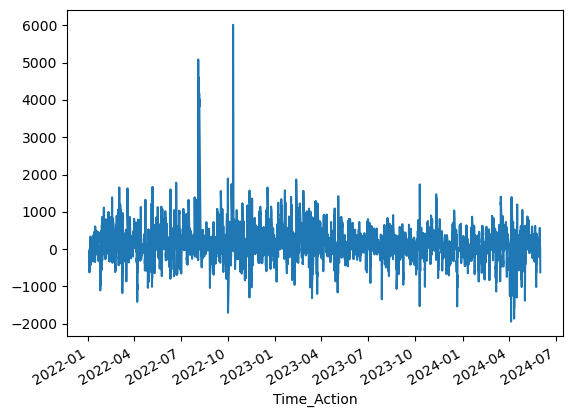

In [55]:
df_ff['PnL'].plot()

In [29]:
df_ff['SPY_Price_diff'] = df_ff['SPY_Price'].astype(float).diff()
df_ff['VIX_Price_diff'] = df_ff['VIX_Price'].astype(float).diff()

In [31]:
df_ff['target'] = df_ff['PnL'].shift(-1)

In [37]:
df_ff

,Options_Delta,Hedge_Delta,Overall_Delta,SPY_Price,Margin_Remaining,AVG_Hedge_Price,VIX_Price,Daily_running_HEDGE_pnl,PUT_pnl,CALL_pnl,Option_pnl,Option_Greeks,PnL,SPY_Price_diff,VIX_Price_diff,target
Time_Action,,,,,,,,,,,,,,,,
2022-01-03 09:45:00,-5.274605,5,-0.274605,477.08,785557.95,477.18,17.36,-50.0,0.0,0.0,0.0,{'SPY 220103C00478000': {'First_Ask': 0.58; ...,-50.0,NaN,NaN,-545.0
2022-01-03 09:50:00,-1.800545,2,0.199455,474.89,832284.47,477.18,18.27,-1145.0,0.0,600.0,600.0,{'SPY 220103C00478000': {'First_Ask': 0.58; ...,-545.0,-2.190,0.91,-575.0
2022-01-03 09:55:00,-2.108250,2,-0.10825,475.04,831953.47,477.18,17.98,-1115.0,0.0,540.0,540.0,{'SPY 220103C00478000': {'First_Ask': 0.58; ...,-575.0,0.150,-0.29,-535.0
2022-01-03 10:00:00,-1.851205,2,0.148795,474.94,832197.47,477.18,18.11,-1135.0,0.0,600.0,600.0,{'SPY 220103C00478000': {'First_Ask': 0.58; ...,-535.0,-0.100,0.13,-503.0
2022-01-03 10:05:00,-2.067706,2,-0.067706,475.25,831702.87,477.18,17.72,-1073.0,0.0,570.0,570.0,{'SPY 220103C00478000': {'First_Ask': 0.58; ...,-503.0,0.310,-0.39,-496.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-31 15:35:00,-0.078774,0,-0.0787738377,522.43,896751.75,0.00,13.73,-1166.0,230.0,720.0,950.0,{'SPY 240531P00518000': {'First_Ask': 0.09; ...,-216.0,0.180,-0.02,-216.0
2024-05-31 15:40:00,-0.094686,0,-0.09468597289,522.59,896463.75,0.00,13.76,-1166.0,230.0,720.0,950.0,{'SPY 240531P00518000': {'First_Ask': 0.09; ...,-216.0,0.160,0.03,-216.0
2024-05-31 15:45:00,-0.375540,0,-0.3755400858,523.81,894252.75,0.00,13.64,-1166.0,230.0,720.0,950.0,{'SPY 240531P00518000': {'First_Ask': 0.09; ...,-216.0,1.220,-0.12,-246.0


In [39]:
data_df = pd.DataFrame()
for i in range(30):
    for feature in ['Options_Delta', 'SPY_Price_diff', 'VIX_Price_diff', 'PnL']:
        data_df[f'{feature}_{i}'] = df_ff[feature].shift(i)

In [41]:
data_df['target'] = df_ff['target']

In [43]:
data_df = data_df.dropna()

In [45]:
X_train, X_test, y_train, y_test = train_test_split(data_df.drop('target', axis = 1), data_df['target'], test_size=0.3)

In [57]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print("Best hyperparameters: ", study.best_params)

[I 2024-09-06 12:47:04,820] A new study created in memory with name: no-name-13323cbc-6049-4da7-a1bb-e544519bb306
